# Power Curve Estimation using Deep Learning
Emer Rodriguez-Formisano - _March 2018_

## Summary


## Introduction
**Deep learning** (DL) is a subset of techniques in the machine learning/AI field that attempts to learn patterns from data using algorithms that are not task-specific (generic). The algorithms are usually based on artificial neural networks made of several hidden layers, hence the word "deep", with also a large number of neurons<sup>[1](#ref1)</sup>. The deeper the network, the higher the model complexity together with its level of abstraction capabilities.

Traditionally, the data scientists had to use statistical techniques and expertise in order to obtain the hand-crafted features, but DL is able to identify and learn the features on its own during the training phase. The approach has been successfully applied to classification tasks in the field of computer vision and voice recognition but it can also be applied to regression tasks such as prediction.

The aim of this notebook is to **experiment and learn** how to apply the Deep Learning methods for **predicting the power generated by a wind turbine using its power curve data**. For those outside the wind industry, power curves represent the relationship between the electricity generated by the wind turbine and the wind speed at a given time<sup>[2](#ref2)</sup>. Besides _predicting the production of wind power_, power curves are also used for _monitoring the production efficiency_ of the wind turbines. 

To challenge the Deep Learning approach, a state-of-the-art reference model was used. In 2015, Lee et al. presented an additive multivariate kernel (AMK) method for power curve estimation<sup>[3](#ref3)</sup>. They did not only write an excellent article but also they make the results reproducible by published the dataset used together with the algorithm in an R package called _kerplus_<sup>[4](#ref4)</sup>. This provided a valueable baseline for the analysis.

The rest of the document is structured as follows. First, the datasets used for training the models are presented together with some visualizations. Second part contains the details about the Neural Network architecture, the hyperparameters selection and the results obtained. The last part contains a brief discussion and the comparison between the DL approach with the paper.    

### Python Environment setup

In [1]:
import pandas as pd
import os
import logging
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Disable Tensorflow GPU

from keras.models import Sequential, load_model
from keras.initializers import he_normal
from keras.layers import Dense, Dropout
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint


# Logging
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
pd.set_option('display.width', 1000)

C:\Users\emerrf\Anaconda3\envs\PCEDL\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Dataset

High quality public available datasets about wind turbine power curves are extremely rare. My sincere gratitude to Lee et al. for sharing the J53 dataset on Internet. The data is made of 1 year of 10 minute records from 6 Wind Turbines (4 onshore and 2 offshore). For the present analysis 2 subsets are going to be used. One is the subset contained in the the R package called _windpw_<sup>[4](#ref4)</sup>. The second subset is all datapoint that belongs to the Wind Turbine 1 (WT1).

#### Dataset description 

| Dataset name  | Num. of records| Num. of variables | Traning size | Test size | Comments                             |
|:-------------:|--------------- | ----------------- | ------------ | --------- |:------------------------------------ |
| windpw        | 1000           | 6                 | 900          | 100       | Random sample from J53 dataset (WT1) |
| WT1           | 47542          | 7                 | 42787        | 4755      | All WT1 datapoints from J53 dataset  |

Note: a quick check of the windpw dataset showed that all its records belong to WT1. Most of them also appear in WT2 because both turbines share the same meteorological mast. 
```R
> table(plyr::match_df(J53_data[,c(id.cov, "WT", "seqNo")],windpw[,id.cov])$WT)
Matching on: V, D, rho, I, Sb

 WT1  WT2  WT3  WT4  WT5  WT6 
1000  972    0    0    0    0 
```

#### Dataset variables

| Codename | Name | Units | Description |
| --- | --- | --- | --- | 
| V | wind speed | m/s | |
| D | wind direction | degree | | 
| rho | air density | kg/m^3 | |
| I | turbulence intensity | | Coeff. of Variation in 10 min intervals I = std(V)/mean(V) |
| Sb | below-hub wind shear | | | 
| y | power | % | normalised power output relative to the rated power |
| seqNo | sequence number | | Sequence that orders the records with respect to time (only available in WT1) |

### Data Loader


In [2]:
WT_TYPES = {"WT1": "shore", "WT2": "shore", "WT3": "shore", "WT4": "shore",
            "WT5": "offshore", "WT6": "offshore"}

J53_VARNAMES = {"Sequence No.": "seqNo", "air density": "rho", "Humidity": "H",
                "S_a": "Sa", "S_b": "Sb", "y (% relative to rated power)": "y"}

def read_J53_data(dir):
    data_list = list()
    for dirpath, _, filenames in os.walk(dir):
        for f in filenames:
            fullpath = os.path.abspath(os.path.join(dirpath, f))
            logger.info("Reading data from: {}".format(fullpath))
            df = pd.read_csv(fullpath, header=0, sep=" ", index_col="Sequence No.")
            df.rename(columns=J53_VARNAMES, inplace=True)
            id = f.split("_")[1].split(".")[0]
            df["WT"] = id
            df["Type"] = WT_TYPES[id]

            data_list.append(df)
    data = pd.concat(data_list)
    return data

# Load J53 Data
J53_data = read_J53_data("PCEDL/data/J53")

def get_dataset(name="WT1"):
    # Name is one of: windpw or WT1
    if(name == "WT1"):

        # Select WT1 data and get order to match R analysis
        wt_data = J53_data.loc[J53_data["WT"] == "WT1",
                               ["V", "D", "rho", "I", "Sb", "y"]]
        wt1_order = pd.read_csv("R/WT1_seqNo_order.csv", header=0)
        wt_data = wt_data.loc[wt1_order["seqNo"], :]

    else:
        # Default dataset: windpw from kernplus R package
        wt_data = pd.read_csv("R/kernplus_windpw.csv")
    
    return wt_data


In [3]:
wt_data = get_dataset("windpw")
wt_data.describe()

,V,D,rho,I,Sb,y
count,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,8.561050,201.95428,1.192818,0.093165,0.243746,52.483180
std,2.877354,90.07896,0.047847,0.054091,0.240803,34.240619
min,3.550000,0.00000,1.109568,0.014839,-0.666431,-0.990000
25%,6.210000,150.12500,1.153046,0.055157,0.092509,19.730000
50%,8.385000,200.15000,1.187288,0.083725,0.217664,51.260000
75%,10.510000,278.42500,1.229758,0.117510,0.379841,85.725000
max,18.780000,359.10000,1.327432,0.385042,1.373158,101.560000


## Data visualization

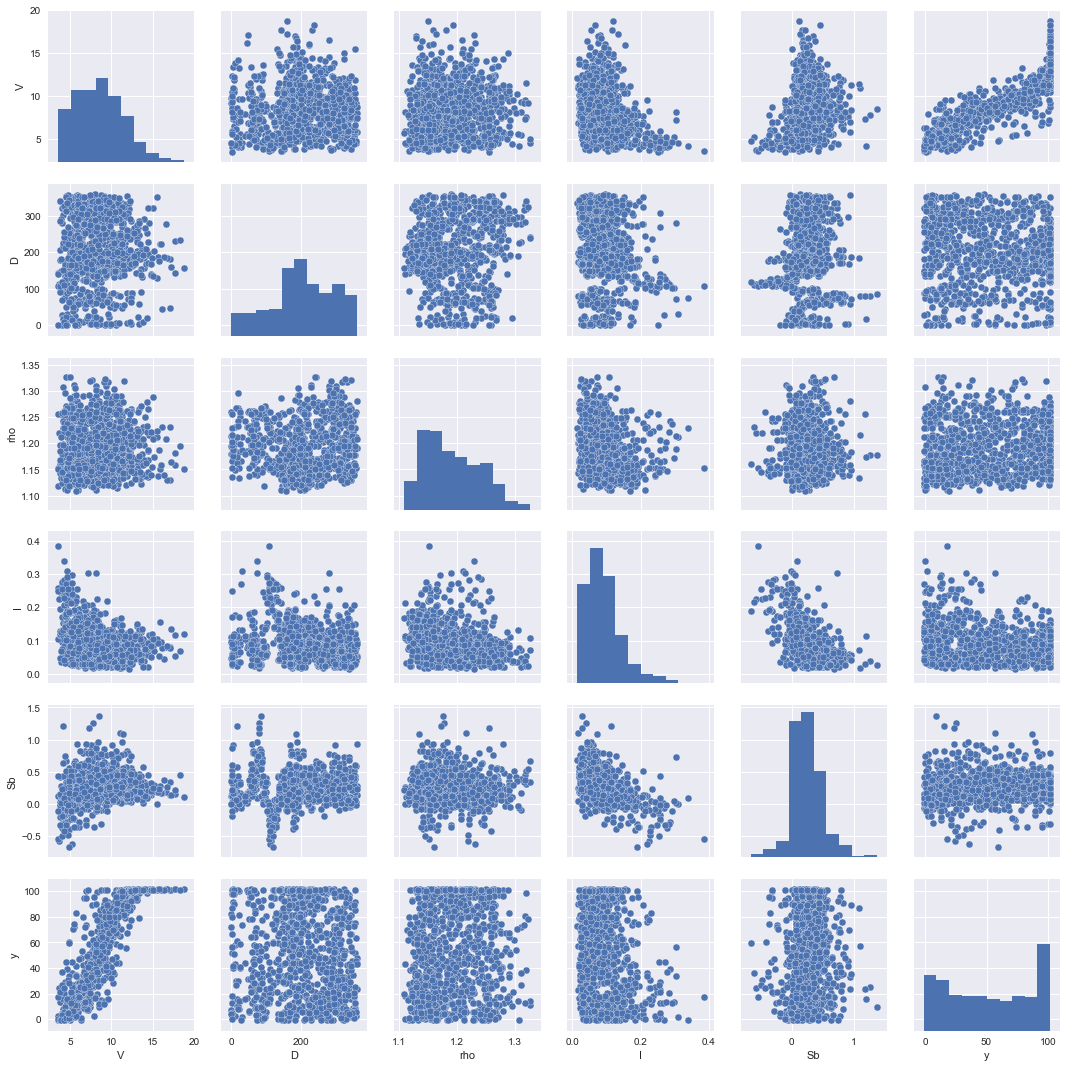

In [4]:
import seaborn as sns
sns.set()
g = sns.pairplot(wt_data)

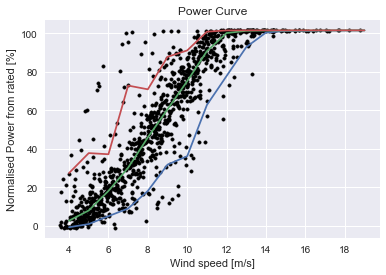

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set()

plt.scatter(wt_data["V"], wt_data["y"], marker='.', color='k')
wt_plot = wt_data.copy()
wt_plot = wt_plot[["V", "y"]]
wt_plot = wt_plot.assign(V=wt_plot["V"].round(0))
def q1(x):
    return np.percentile(x, 5)
def q2(x):
    return np.percentile(x, 50)
def q3(x):
    return np.percentile(x, 95)

lines_data = wt_plot.groupby(by="V").agg({"y": [q1, q2, q3]})
plt.plot(lines_data)
plt.xlabel("Wind speed [m/s]")
plt.ylabel("Normalised Power from rated [%]")
plt.title("Power Curve")
plt.show()

## Initial Model

## Notes to be removed

Thisis text from Et al.<sup>[1](#ref1)</sup> continue here.


Nevertheless, actual wind power data indicate that the power output is affected by more than just wind speed. Several other environmental factors, such as wind direction, air density, humidity, turbulence intensity, and wind shears, have potential impact. Yet, in industry practice, as well as in the literature, current power curve models primarily consider wind speed and, sometimes, wind speed and direction. 


We propose an additive multivariate kernel method that can include the aforementioned environmental factors as a new power curve model. Our model provides, conditional on a given environmental condition, both the point estimation and density estimation of power output. It is able to capture the nonlinear relationships between environmental factors and the wind power output, as well as the high-order interaction effects among some of the environmental factors. Using operational data associated with four turbines in an inland wind farm and two turbines in an offshore wind farm, we demonstrate the improvement achieved by our kernel method.


## References
<a name="ref1">[1]</a>: Brownlee, Jason. "What is Deep Learning?" Machine Learning Masteri. August 16, 2016. [Web](https://machinelearningmastery.com/what-is-deep-learning/). March 2018

<a name="ref2">[2]</a>: "Wind turbine power ouput variation with steady wind speed." Wind Power Program. [Web](http://www.wind-power-program.com/turbine_characteristics.htm). March 2018


<a name="ref3">[3]</a>: Lee, Ding, Genton, and Xie, 2015, “Power curve estimation with multivariate environmental factors for inland and offshore wind farms,” Journal of the American Statistical Association, Vol. 110, pp. 56-67. [[pdf]](http://aml.engr.tamu.edu/wp-content/uploads/sites/164/2017/11/J53.pdf) [[data]](https://tamucs-my.sharepoint.com/personal/yu-ding_tamu_edu/_layouts/15/guestaccess.aspx?docid=02ca342aff3b14e0b8267b2e8439d4ebb&authkey=AQZ_SN1Ra8BlDfPBfqraLlU&e=4c97b6b8ec3343beab3e42eae8354a69) _Note: The datasets shared here include the normalized power, a percentage relative to the rated power.  Some of the tables in the paper may not be precisely reproducible using the normalized power data.  But the relative performance of the methods should remain in the same order._ [Web](https://aml.engr.tamu.edu/2001/09/01/publications/). March 2018

<a name="ref4">[4]</a>: Yu Ding and Hoon Hwangbo (2017). kernplus: A Kernel Regression-Based Multidimensional Wind Turbine Power Curve. R package version 0.1.0. https://CRAN.R-project.org/package=kernplus


<a name="ref1">[n]</a>: S. Andrew Ning. A simple solution method for the blade element momentum equations with guaranteed convergence. Wind Energy, June 2013. doi:10.1002/we.1636.